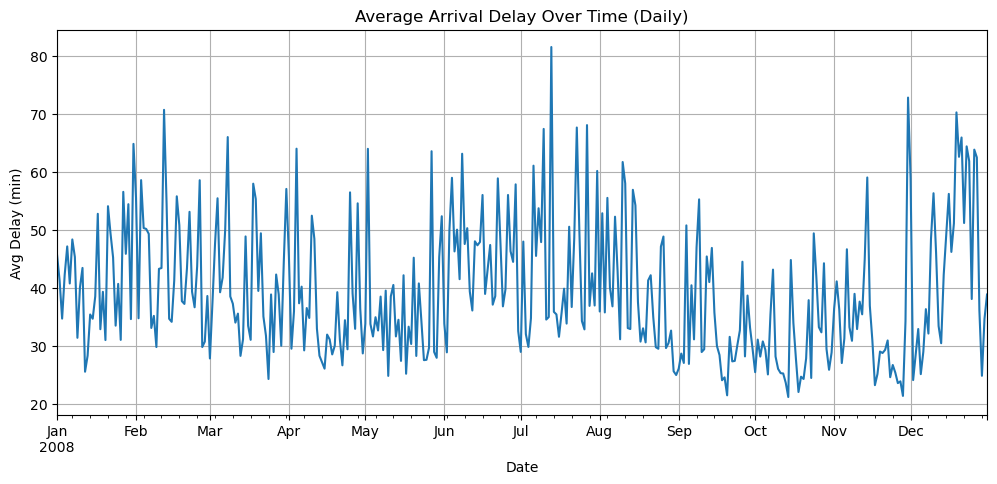

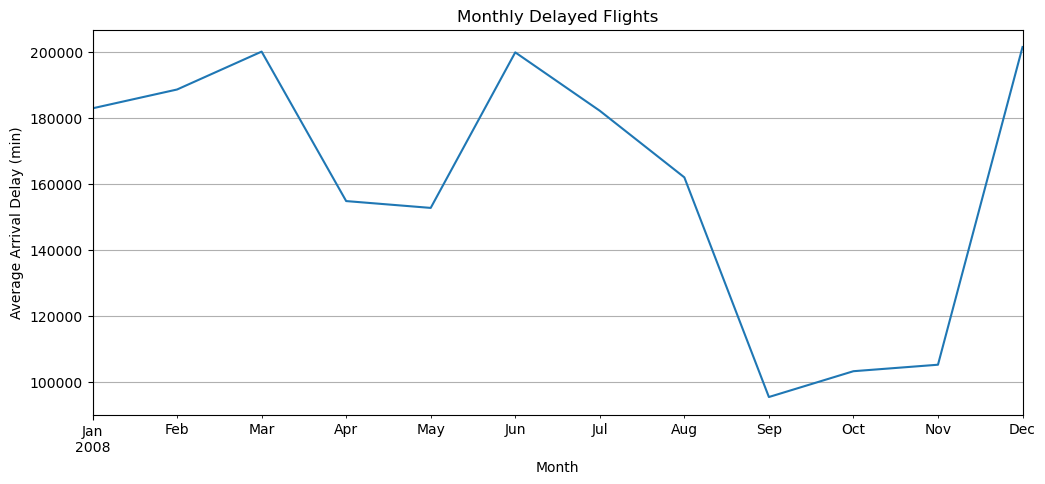

Descriptive statistics:
count    366.000000
mean      39.303915
std       11.394382
min       21.152778
25%       30.480518
50%       36.467705
75%       46.911466
max       81.465869
Name: ArrDelay, dtype: float64

ADF Test Results:
ADF Statistic: -5.717580238755727
p-value: 7.06240769325501e-07
Critical Value (1%): -3.448544133483233
Critical Value (5%): -2.8695574079525565
Critical Value (10%): -2.5710411593052713


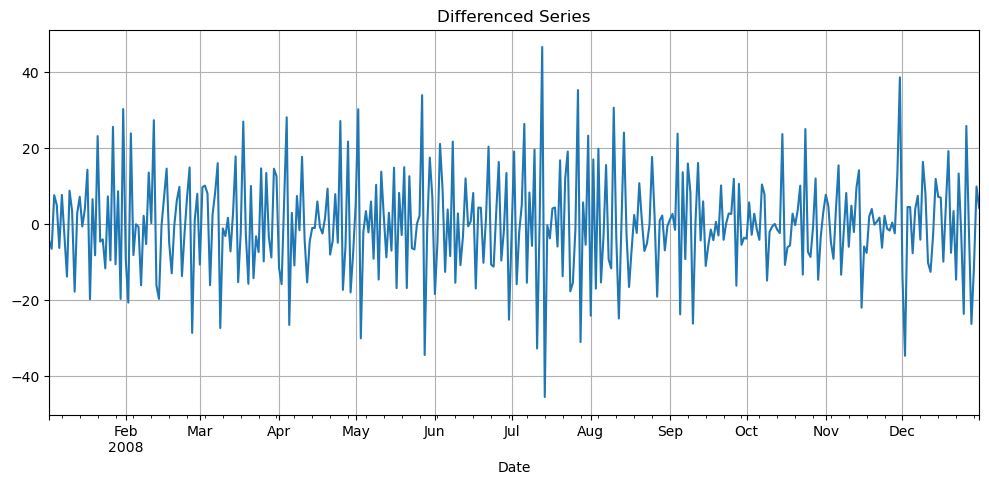

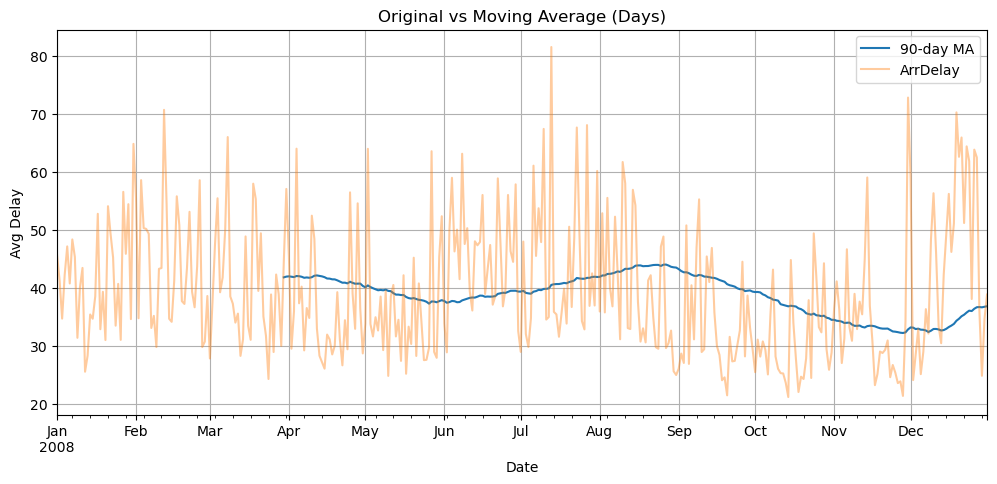

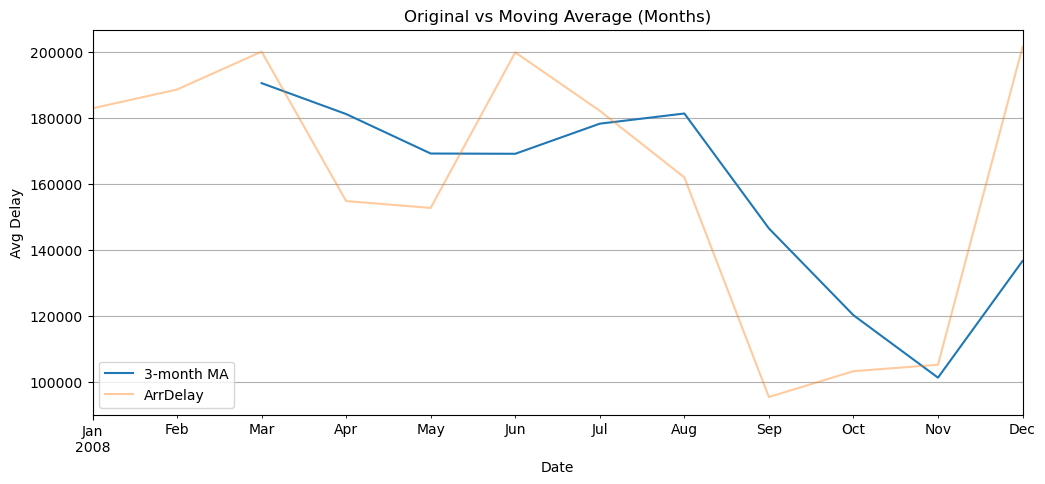


ADF Statistic after differencing: -8.151745877818174
p-value after differencing: 9.654554309436726e-13


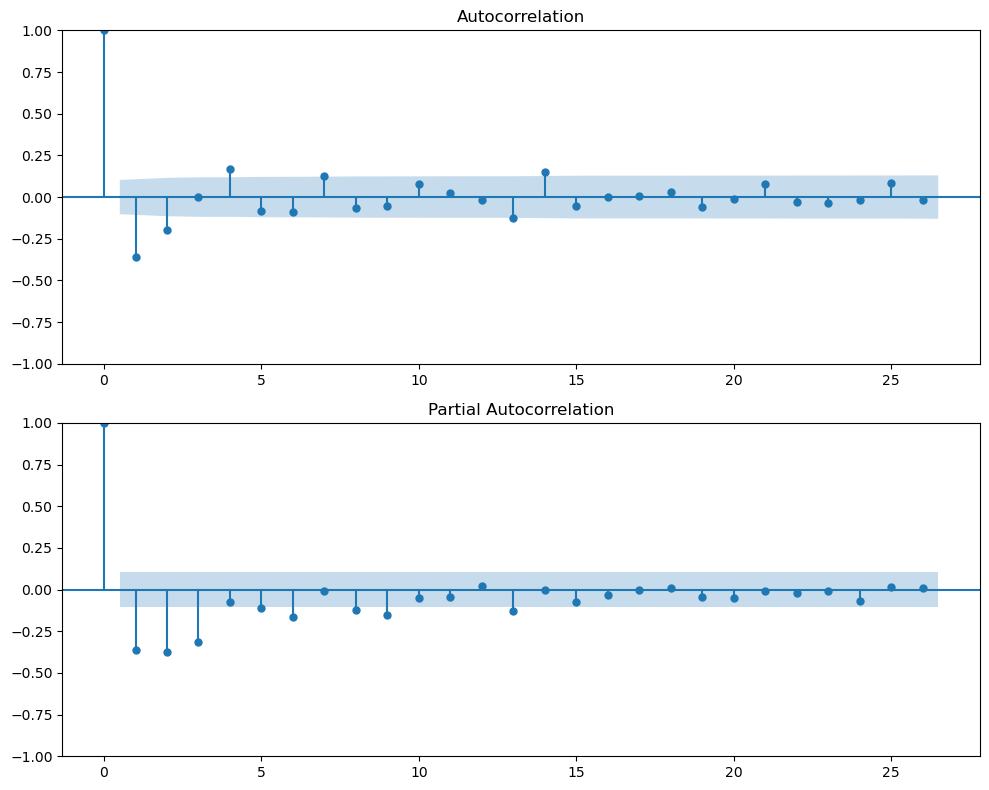

                               SARIMAX Results                                
Dep. Variable:               ArrDelay   No. Observations:                  366
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1370.444
Date:                Sun, 27 Apr 2025   AIC                           2756.889
Time:                        16:24:26   BIC                           2788.088
Sample:                    01-01-2008   HQIC                          2769.288
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1962      0.062      3.153      0.002       0.074       0.318
ar.L2         -0.0768      0.068     -1.137      0.256      -0.209       0.056
ar.L3          0.0458      0.061      0.750      0.4

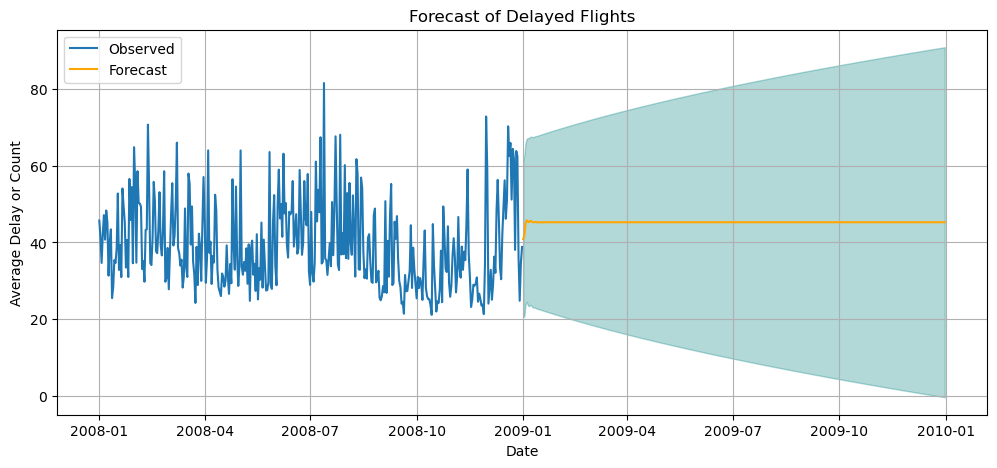


Model Evaluation Metrics:
MAE: 11.08
RMSE: 12.87


In [4]:
# Time Series Analysis: Delayed Flights Dataset
# In this notebook, we forecast the number of delayed flights over time using ARIMA. 
# The goal is to predict delays for the next 12 months.

# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('~/Downloads/archive-3/DelayedFlights.csv')

# Preprocessing through filter and handling missing values
# Making sure that the to_datetime() gets the correct columns 
df = df.dropna(subset=['ArrDelay'])  # focusing on arrival delay
df['Date'] = pd.to_datetime({'year': df['Year'],'month': df['Month'],'day': df['DayofMonth']})
df = df.sort_values('Date')

# Transform data to daily time series
df_ts = df.groupby('Date')['ArrDelay'].mean()
df_ts = df_ts.asfreq('D')  # daily frequency

# Visualize trends and seasonality
df_ts.plot(title='Average Arrival Delay Over Time (Daily)', figsize=(12,5))
plt.xlabel("Date")
plt.ylabel("Avg Delay (min)")
plt.grid(True)
plt.show()

# Adding delays for monthly
monthly_delays = df.groupby(pd.Grouper(key='Date', freq='MS'))['ArrDelay'].size()

# Fill missing months if needed
monthly_delays = monthly_delays.asfreq('MS')

#  Monthly time series plot
monthly_delays.plot(title='Monthly Delayed Flights', figsize=(12, 5))
plt.ylabel("Average Arrival Delay (min)")
plt.xlabel("Month")
plt.grid(True)
plt.show()


#  Descriptive statistics
print("Descriptive statistics:")
print(df_ts.describe())

# Check for stationarity using adfuller()
adf_result = adfuller(df_ts.dropna())
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")


# TO Compare I need to first apply the differencing
ts_diff = df_ts.diff().dropna()

# Plotting the differenced series
ts_diff.plot(title="Differenced Series", figsize=(12, 5))
plt.grid(True)
plt.show()

# Performing the smoothing as needed and comparing it with the original
# Plotting the 90-month moving average vs the original
# Notice the seasonal spikes as it increase throughout the year like in July/December
df_ts.rolling(window=90).mean().plot(label='90-day MA', figsize=(12,5))
df_ts.plot(alpha=0.4)
plt.title("Original vs Moving Average (Days)")
plt.xlabel("Date")
plt.ylabel("Avg Delay")
plt.legend()
plt.grid(True)
plt.show()

# Performing the smoothing for months
monthly_delays.rolling(window=3).mean().plot(label='3-month MA', figsize=(12,5))
monthly_delays.plot(alpha=0.4)
plt.title("Original vs Moving Average (Months)")
plt.xlabel("Date")
plt.ylabel("Avg Delay")
plt.legend()
plt.grid(True)
plt.show()

# Rerunning ADF on differenced series to confirm stationarity
result = adfuller(ts_diff)
print(f"\nADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")

# Differencing if non stationary
df_diff = df_ts.diff().dropna()

# Plotting ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(df_diff, ax=ax[0])
plot_pacf(df_diff, ax=ax[1])
plt.tight_layout()
plt.show()

# ARIMA Model adjusted based on ACF and PACF
model = ARIMA(df_ts, order=(6,1,1)) 
model_fit = model.fit()
print(model_fit.summary())

# Forecast next 12 months/ 365 days
# As ARIMA needs more than 12 periods we'll use days over months here
forecast = model_fit.get_forecast(steps=365)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12, 5))
plt.plot(df_ts, label='Observed') 
plt.plot(forecast_df['mean'], label='Forecast', color='orange')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='teal', alpha=0.3)

plt.title("Forecast of Delayed Flights")
plt.xlabel("Date")
plt.ylabel("Average Delay or Count")  
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model Performance
#Train with 6 months of data 
train = df_ts[:-180]
test = df_ts[-180:]

# Model and the model predictions
model_eval = ARIMA(train, order=(6,1,1))
model_eval_fit = model_eval.fit()
preds = model_eval_fit.forecast(steps=180) # Same number of steps

# MAE and RMSE the appropriate metrics
mae = mean_absolute_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))
print(f"\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


# In this analysis, I successfully developed a time series forecasting model 
# using the ARIMA(6,1,1) configuration to predict the number of delayed flights 
# over the next 12 months.

# The dataset was first transformed into a daily time series, followed by 
# smoothing and differencing to address nonstationarity.

# After reviewing ACF and PACF plots, the selected ARIMA model was trained 
# and validated, yielding an MAE of 11.08 and an RMSE of 12.87. 
# These values suggest an accurate forecast model, with average 
# deviations in delay prediction.
# The seasonal trends especially spikes around mid-year 
# and year-end were captured by the model.

# Overall, the forecasting framework demonstrates a solid application 
# of ARIMA for airline delay prediction.